## Logistic Regression for the MNIST dataset

In this notebook we will continue using Pytorch. Now, we will create a shallow model (the logistic regression), plus the full training pipeline in order to train and evaluate this model over the MNIST dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Next, we will define some hyperparameters and config options

In [2]:
# Set the random seed, so the experiment is reproducible
seed = 0
torch.manual_seed(seed)
# For the moment, we will just train on CPU, so no cuda
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
# We use a batch size of 32 examples while training, and 1000 while testing
batch_size = 32
test_batch_size = 1000
# We will use SGD with a momentum term
momentum = 0.5
# The learning rate
lr = 0.01
# The number of epochs
epochs = 3
# The size of the input. MNIST are greyscale images, 28x28 pixels each
im_size = 28*28

Now, we are ready to define our pytorch model. This is done by creating a class that extends nn.Module, with two methods:

* __init__ : used to define and initialize the parameters of the model (for the LR, this is just a weight matrix of size 28*28 x 10, since we want to project to a 10-dimensional space to predict the digit. We could have define this explicitly, but with pytorch we have nn.Linear which is a shorthand for a linear projection.

* forward: used to define the computation in the model. We just want to apply the linear projection to the input, and then the softmax transformation (so that the output of the model can be interpreted as a probability distribution over the 10 digits).

Two things to note:

1. Since the images are tensors of size 28x28, and the Linear operator expects a 1-d array (since it is the operation Wx), we need to flatten the image using the method view (as a reshape).
2. Since the loss function is nll_loss (see next cell), it expects the input to be in log space, thats why we use log_softmax instead of softmax (see https://pytorch.org/docs/stable/nn.functional.html#log-softmax)

In [3]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.lin = nn.Linear(im_size, 10)

    def forward(self, x):
        x_flat = x.view(-1, im_size)
        return F.log_softmax(self.lin(x_flat), dim=1)

Next, we define the training loop.
For each minibatch (obtained using enumerate(train_loader) (see later for how the dataset is generated), we do the following:

1. Move x, y (data, target) to the GPU if necessary (using .to(device))
2. Reset the gradients to zero (from previous iterations) using .zero_grad()
3. Forward pass: we compute the predictions using model(data) (which is y = f(x) with f being the logistic regression)
4. Backward pass: we compute the gradients using .backward(), and then we apply one step of the optimizer, that is performing $w \leftarrow w - lr * \nabla (loss(f(x), y)$ for the case of gradient descent.

In [4]:
def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())

We can also create a function to evaluate our model. It is very similar to the previous one, but the main differences are:
    
1. We use torch.no_grad() to prevent gradient computations and changing the weights of the model.
2. Once we have the predicted distribution, we use .argmax to compute the most probable digit. We also compute the accuracy of our model

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Now, we are going to load the dataset. Since the MNIST dataset is very popular, PyTorch already has it included into datasets.MNIST, and will automatically download it the first time. We can also specify some transformations, like converting the matrix to a tensor and normalize the pixels

Note that we create two data loaders: one for the training set and another one for the testing set. Since this is just a quick experiment, we are not going to validate the initial hyperparameters, so we don't create another data loader for a validation set.

The main benefit of the DataLoader class is that it creates an object which can be used in a for loop, as we did in the previous train function, to iterate over the minibatches.

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

Let's visualize some examples together with the true labels.

In [7]:
examples = enumerate(test_loader)
batch_idx, (example, label) = next(examples)
example.shape

torch.Size([1000, 1, 28, 28])

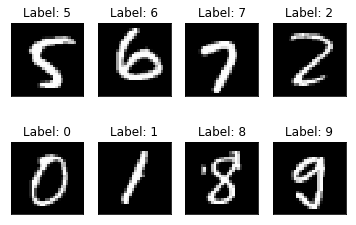

In [8]:
fig = plt.figure()
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(example[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
fig

Now, we are almost done! We just instantiate the model, and tell which optimizer are we going to use, in this case, stochastic gradient descent

In [9]:
model = LogisticRegression().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

And finally, a simple loop over the number of epochs. This should take over a few minutes in a simple laptop cpu..

In [10]:
train_losses = []
for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, train_losses)
        test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.451776
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.747278
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.607951
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.449380
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.344543
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.172929
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.434396
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.192195
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.384779
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.489098
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.262179
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.172913
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.657756
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.335815
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.254254
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.438054
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.184763
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.156785
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.219509

Test set: Average loss: 0.2898, Accuracy: 9176/10000 (92%)

Let's visualize the training losses

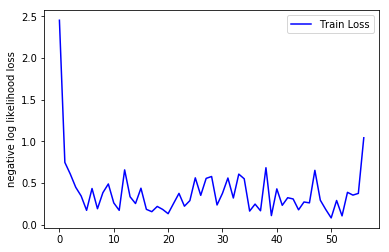

In [12]:
fig = plt.figure()
plt.plot(range(len(train_losses)), train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.ylabel('negative log likelihood loss')
fig

As our first attemp, we obtained over 92% accuracy, which is not so bad, but soon we will see how to vastly improve on this result!

## Multilayer Perceptron for MNIST dataset

We will try to improve the previous results by training a deeper network. 

### Train MLP
First of all, define the forward pass. We propose to use one hidden FC layer with 50 units, and an output layer with `log_softmax` activation, but feel free to create the network you prefer!

In [13]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

Now, we initialize the network and choose the optimizer. We propose using SGD optimizer. Set the `learning_rate` to 0.01 and the `momentum` to 0.5.

In [15]:
learning_rate = 0.01
momentum = 0.5
model = MLP().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

Now let's train the model during 3 epochs. For monitoring purposes, print the training loss every 100 batches and store it.

In [18]:
training_losses = []
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, training_losses)
    test(model, device, test_loader)

/home/roi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333978
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.702726
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.553314
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.447418
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.381252
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.444157
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.156283
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.153781
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.273984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.191273
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.143926
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.249884
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.378720
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.334598
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.330522
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.350831
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.089973
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.144599
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.167678

Test set: Average loss: 0.2270, Accuracy: 9338/10000 (93%)

Let's plot the training loss

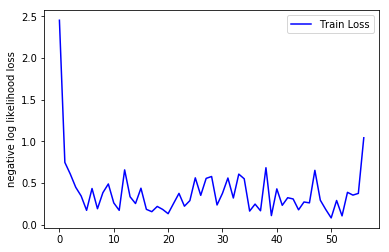

In [19]:
fig = plt.figure()
plt.plot(range(len(train_losses)), train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.ylabel('negative log likelihood loss')
fig

We have 96% acccuracy!